In [26]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [28]:
loaded_model = pickle.load(open('finalized_selin.sav', 'rb'))
test_data = pd.read_excel('Test_Data.xlsx')
y_test =  pd.read_excel('Test_Data_Actual.xlsx')

y_test["NK_FLAG"] = y_test["Actual (NK_FLAG)"]
test_data.drop(columns="INDEX", inplace=True)
test_data.drop(columns="NK_FLAG", inplace=True)
y_test.drop(columns="ID", inplace=True)
y_test.drop(columns="Actual (NK_FLAG)", inplace=True)
result_data = test_data.copy()
df=test_data.copy()

df_na = df[(df.iloc[:,:].isnull().any(axis=1))].index.to_list()
df['TUKETIM_NAN'] = 0
df.loc[df_na, 'TUKETIM_NAN'] = 1

# bazı kolonların silinmesi
df.drop(['SAYAC_BITIS_TARIHI' ,'SAYAC_MALZEME_ID', 'SAYAC_BASLANGIC_TARIHI'], axis = 1, inplace=True)

# TUKETIM_MX kolonlarındaki NaN değerleri satırların 0 ile doldurulması
zero_tuk_val = df.iloc[:,0:24].columns.to_list()
df[zero_tuk_val] = df[zero_tuk_val].fillna(0)

# DEMAND_MX kolonlarındaki NaN değerleri satırların 0 ile doldurulması
zero_dem_val = df.iloc[:,24:39].columns.to_list()
df[zero_dem_val] = df[zero_dem_val].fillna(0)

# SAYAC_MODEL ve SAYAC_MARKA kolonlarındaki NaN değerlerin MISSING ile doldurulması
df['SAYAC_MODEL'] = df['SAYAC_MODEL'].fillna('MISSING')
df['SAYAC_MARKA'] = df['SAYAC_MARKA'].fillna('MISSING')

# SAYAC_OLCUM_TURU kolonundaki NaN değerlerin Kombi ile doldurulması
df['SAYAC_OLCUM_TURU'] = df['SAYAC_OLCUM_TURU'].fillna('Kombi')

# SAYAC_YAPIM_YILI kolonundaki NaN değerlerin 9999 ile doldurulması
df['SAYAC_YAPIM_YILI'] = df['SAYAC_YAPIM_YILI'].fillna(9999)

# SAYAC_FAZ_N kolonundaki NAN değerlerin TESISAT_TIPI kolonuna göre doldurulması
# TESISAT_TIPI Ticarethane-Sanayi ise Trifaze olarak doldurulur.
# TESISAT_TIPI Mesken ise Monofaze olarak doldurulur.
tic_val = df[(df['TESISAT_TIPI'] == 'Ticarethane-Sanayi')]
tic_val = tic_val[(tic_val['SAYAC_FAZ_N'] != 'Monofaze') & (tic_val['SAYAC_FAZ_N'] != 'Trifaze')]
index_tic_val = tic_val.index.tolist()
df.loc[index_tic_val, 'SAYAC_FAZ_N'] = 'Trifaze'

mes_val = df[(df['TESISAT_TIPI'] == 'Mesken')]
mes_val = mes_val[(mes_val['SAYAC_FAZ_N'] != 'Monofaze') & (mes_val['SAYAC_FAZ_N'] != 'Trifaze')]
index_mes_val = mes_val.index.tolist()
df.loc[index_mes_val, 'SAYAC_FAZ_N'] = 'Monofaze'

# 
df['TESISAT_TIPI'] = df['TESISAT_TIPI'].str.replace('Mesken', '1')
df['TESISAT_TIPI'] = df['TESISAT_TIPI'].str.replace('Ticarethane-Sanayi', '0')
df['TESISAT_TIPI'] = df['TESISAT_TIPI'].astype(int)

df['SAYAC_OLCUM_TURU'] = df['SAYAC_OLCUM_TURU'].str.replace('Aktif', '1')
df['SAYAC_OLCUM_TURU'] = df['SAYAC_OLCUM_TURU'].str.replace('Kombi', '0')
df['SAYAC_OLCUM_TURU'] = df['SAYAC_OLCUM_TURU'].astype(int)

df['SAYAC_FAZ_N'] = df['SAYAC_FAZ_N'].str.replace('Monofaze', '1')
df['SAYAC_FAZ_N'] = df['SAYAC_FAZ_N'].str.replace('Trifaze', '0')
df['SAYAC_FAZ_N'] = df['SAYAC_FAZ_N'].astype(int)

# SAYAC_MARKA gruplaması
for i in range(len(df['SAYAC_MARKA'])):    

    if (df['SAYAC_MARKA'][i] == 'KAAN') | (df['SAYAC_MARKA'][i] == 'MAKEL') | (df['SAYAC_MARKA'][i] == 'KOHLER'):
        df.loc[i, 'SAYAC_MARKA'] = 'KAAN-MAKEL-KOHLER'
    elif (df['SAYAC_MARKA'][i] == 'ELEKTROMED') | (df['SAYAC_MARKA'][i] == 'VI-KO') :
        df.loc[i, 'SAYAC_MARKA'] = 'ELEKTROMED-VI-KO'
    elif (df['SAYAC_MARKA'][i] == 'DMA') | (df['SAYAC_MARKA'][i] == 'NORA'):
        df.loc[i, 'SAYAC_MARKA'] = 'DMA-NORA'

# SAYAC_MODEL gruplaması
for i in range(len(df['SAYAC_MODEL'])):    

    if (df['SAYAC_MODEL'][i] == 'EC25TPA3CHB') | (df['SAYAC_MODEL'][i] == 'AEL.TF.16-2') | (df['SAYAC_MODEL'][i] == 'AEL.MF.11') | (df['SAYAC_MODEL'][i] == 'LSM-35 HBR') | (df['SAYAC_MODEL'][i] == 'LSM35-KM') | (df['SAYAC_MODEL'][i] == 'LUN23 TF') | (df['SAYAC_MODEL'][i] == 'LUN10-B') | (df['SAYAC_MODEL'][i] == 'M560.2251S') | (df['SAYAC_MODEL'][i] == 'M600.2251') | (df['SAYAC_MODEL'][i] == 'LUN10 HBR'):
        df.loc[i, 'SAYAC_MODEL'] = 'GROUP-1'                                                  
    elif (df['SAYAC_MODEL'][i] == 'EC058MCT')  | (df['SAYAC_MODEL'][i] == 'LSM-35') | (df['SAYAC_MODEL'][i] == 'LUN10') | (df['SAYAC_MODEL'][i] == 'M500.2211') | (df['SAYAC_MODEL'][i] == 'VEM-M580DB0E') | (df['SAYAC_MODEL'][i] == 'VEM-T5100DB2') | (df['SAYAC_MODEL'][i] == 'T510.2251') | (df['SAYAC_MODEL'][i] == 'VEM-T5100DB0E'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-2'                                                  
    elif (df['SAYAC_MODEL'][i] == 'AEL.MF.07')  | (df['SAYAC_MODEL'][i] == 'DA 1118') | (df['SAYAC_MODEL'][i] == 'EC058MBW') | (df['SAYAC_MODEL'][i] == 'LUN21') | (df['SAYAC_MODEL'][i] == 'M500.2251') | (df['SAYAC_MODEL'][i] == 'VEM-M580DB0') | (df['SAYAC_MODEL'][i] == 'VEM-T5100DB0'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-3'                                                   
    elif (df['SAYAC_MODEL'][i] == 'AEL.TF.16') | (df['SAYAC_MODEL'][i] == 'EC018MBW') | (df['SAYAC_MODEL'][i] == 'LUN1') | (df['SAYAC_MODEL'][i] == 'M310.2218'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-4'                                                  
    elif (df['SAYAC_MODEL'][i] == 'EC15ATBW') | (df['SAYAC_MODEL'][i] == 'EC11ATBW'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-5'                                                   
    elif (df['SAYAC_MODEL'][i] == 'M550.2251'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-6'    
    else:
        df.loc[i, 'SAYAC_MODEL'] = 'OTHER'
                                                   

# yeni kolon : 'SAYAC_YAS'
df['SAYAC_YAS'] = (df['SAYAC_TAKILMA_TARIHI'].dt.year)-df['SAYAC_YAPIM_YILI']
df["SAYAC_YAS"] = df["SAYAC_YAS"].fillna(0)

# SAYAC_YAS gruplaması
for i in range(len(df['SAYAC_YAS'])):    

    if (df['SAYAC_YAS'][i] == 4.0) | (df['SAYAC_YAS'][i] == 5.0) | (df['SAYAC_YAS'][i] == 6.0):
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-1'
    elif (df['SAYAC_YAS'][i] == 0.0) | (df['SAYAC_YAS'][i] == 1.0) :
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-2'
    elif (df['SAYAC_YAS'][i] == 7.0) | (df['SAYAC_YAS'][i] == 8.0) | (df['SAYAC_YAS'][i] == 9.0):
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-3'
    elif (df['SAYAC_YAS'][i] == 2.0):
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-5'
    elif (df['SAYAC_YAS'][i] == 3.0):
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-6'
    else:
        df.loc[i, 'SAYAC_YAS'] = 'OTHER'        
        
# SAYAC_YAPIM_YILI gruplaması
for i in range(len(df['SAYAC_YAPIM_YILI'])):    

    if (df['SAYAC_YAPIM_YILI'][i] == 2007.0) | (df['SAYAC_YAPIM_YILI'][i] == 2008.0) | (df['SAYAC_YAPIM_YILI'][i] == 2009.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-1'
    elif (df['SAYAC_YAPIM_YILI'][i] == 2010.0) | (df['SAYAC_YAPIM_YILI'][i] == 2011.0) | (df['SAYAC_YAPIM_YILI'][i] == 2012.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-2'
    elif (df['SAYAC_YAPIM_YILI'][i] == 2013.0) | (df['SAYAC_YAPIM_YILI'][i] == 2014.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-3'
    elif (df['SAYAC_YAPIM_YILI'][i] == 2015.0) | (df['SAYAC_YAPIM_YILI'][i] == 2016.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-4'
    elif (df['SAYAC_YAPIM_YILI'][i] == 2017.0) | (df['SAYAC_YAPIM_YILI'][i] == 2018.0) | (df['SAYAC_YAPIM_YILI'][i] == 2019.0) | (df['SAYAC_YAPIM_YILI'][i] == 2020.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-5'
    else:
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'OTHER'  
             
# yeni kolon : 'RISK_VE_OLCUM'
risk_and_msrt = df[(df['SOKAK_RISK_SKORU'] > df['MAHALLE_RISK_SKORU']) & (df['SAYAC_OLCUM_TURU'] == 'Kombi')]
index_risk_msrt = risk_and_msrt.index.tolist()
df['RISK_VE_OLCUM'] = 0
df.loc[index_risk_msrt, 'RISK_VE_OLCUM'] = 1
    
# yeni kolon : 'TUKETIM_OUTLIER'
index = []
for i in range(df.shape[0]):
    for j in range(24):
        Q1 = np.quantile(df.iloc[:,j], 0.25)
        Q3 = np.quantile(df.iloc[:,j], 0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        if ((df.iloc[i,j] < lower_bound) | (df.iloc[i,j] > upper_bound)):
            index.append(i)
outliers = set(index)
tuketim_outlier = df.loc[outliers, :]
index_outlier = tuketim_outlier.index.to_list()
df['TUKETIM_OUTLIER'] = 0
df.loc[index_outlier, 'TUKETIM_OUTLIER'] = 1

df.drop(['SAYAC_TAKILMA_TARIHI'], axis = 1, inplace=True)

       
test_data=df.copy()
    
test_data.iloc[:,:24] = test_data.iloc[:, :24].fillna(0)

cat_values = [i for i in test_data if test_data[i].dtype == 'object']

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_fit = enc.fit(test_data[cat_values])
enc_fit_df = pd.DataFrame(enc_fit.fit_transform(test_data[cat_values]))
test_data.reset_index(drop=True, inplace=True)
test_data = test_data.join(enc_fit_df)
test_data.drop(columns=cat_values, axis=1, inplace=True)

sc = StandardScaler()
test_data = sc.fit_transform(test_data)

preds = loaded_model.predict(test_data)
result_data['NK_FLAG'] = preds
result_data.to_excel('result.xlsx')

C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4687
           1       0.45      0.74      0.56       313

    accuracy                           0.93      5000
   macro avg       0.72      0.84      0.76      5000
weighted avg       0.95      0.93      0.94      5000



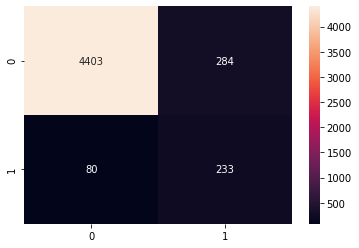

In [30]:
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True, fmt='g')
cm = confusion_matrix(y_test, preds)
sns;